C:\Users\16028\anaconda3\envs\py38_google_b3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


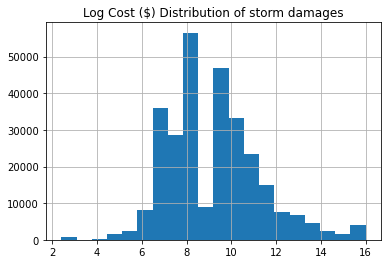

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May  2 14:04:27 2022

@author: 16028
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Apr 15 19:28:53 2022

@author: 16028
"""

import os
if os.getcwd() != r'C:\Users\16028\Downloads\ML-Climate-Final-Project-Template\src':
    os.chdir(r'C:\Users\16028\Downloads\ML-Climate-Final-Project-Template\src')
    print(os.getcwd())
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import datetime as dt
from datetime import timedelta
import glob

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from prophet import Prophet
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor, Pool


from temp_state_dict_working import getCodeToAreaDict, getAreaToCodeDict, monthToNumberDict
from useful_code import correctDamageProp
from state_to_neighbor_dict import get_state_border_dict
from saving_files_locally import get_df_dict
from us_state_to_abbrev import get_us_state_to_abbrev




interimDataPath = r'C:\Users\16028\Downloads\storm_details'
df = pd.read_csv(interimDataPath + '\interm_dataframe_2000_on.csv')

# FITLERS
damge_cost_vc = df.damage_cost.value_counts()
df = df[df['damage_property'] > 0]
df['damge_property'] = df['damage_property']/1000000
df['log_cost'] = np.log(df['damage_cost']+1)
df.log_cost.value_counts()
df['log_cost'] = df['log_cost'].clip(upper=16) #***

### PLOT
plt.hist(df['log_cost'], bins=20)
plt.grid()
plt.title('Log Cost ($) Distribution of storm damages')
plt.show()
# df['season'] = df['month'].apply(mapToSeason)

        
BASE_YEAR = 1980 #***
df['year'] = df['begin_yearmonth'].astype(str).str[:4].astype(int)
df['month'] = df['begin_yearmonth'].astype(str).str[4:].astype(int)
df['years_since'] = df['year'] - BASE_YEAR

df['days_since'] = df['years_since']*365 + df['month']*12 + df['begin_day']
df.event_type.value_counts()
storm_types = list(df.event_type.value_counts().keys())
storm_types

df.event_type.value_counts()
storm_exclusion_list = ['Drought', 'Heat', 'Excessive Heat', 'High Surf', 'Wildfire',
                        'Coastal Flood', 'Avalanche', 'Dust Devil', 'Cold/Wind Chill',
                        'Rip Current', 'Tornado', 'Lake-Effect Snow', 'Dense Fog',
                        'Avalanche', 'Marine High Wind', 'Funnel Cloud', 'Rip Current',
                        'Volcanic Ash', 'Dense Smoke']

df = df[~df['event_type'].isin(storm_exclusion_list)]
df['num_storms'] = 1 #used later for aggregating and counting the number of storms per state
df.columns

state_vc = df.state.value_counts()

state_exclusion_list = ['ALASKA', 'ATLANTIC NORTH', 'GULF OF MEXICO', 'HAWAII', 'ATLANTIC SOUTH', 'PUERTO RICO', 
 'LAKE MICHIGAN', 'LAKE ERIE', 'LAKE HURON', 'LAKE SUPERIOR',]

def correctDC(x):
    if x == 'DISTRICT OF COLUMBIA':
        return 'VIRGINIA'
    else:
        return x
df['state'] = df['state'].apply(correctDC)
df = df[~df['state'].isin(state_exclusion_list)]

a = df.state.value_counts()
df = df.groupby("state").filter(lambda x: len(x) > 511)


sum_df = df.groupby(['year', 'state']).agg({'log_cost': 'sum', 'num_storms': 'sum'}) #*** took out month
###########################################
# sum_df = pd.read_csv(r'sum_df_v3.csv')
###########################################
# sum_df.to_csv('sum_df_yearly.csv')
###########################################


## THIS WAS FOR ASSESSMENT OF CURRENT STORM CONDITIONS IN STATES
# TODO
##########################################################################################
sum_df3 = df.groupby(['year', 'state']).agg({'log_cost': 'sum', 'num_storms': 'sum'})
sum_df4 = sum_df3.reset_index()
sum_df4 = sum_df4[sum_df4['year']>2014]

sum_df4 = sum_df4.groupby('state').agg({'log_cost': 'sum', 'num_storms':'sum'})


sum_df6 = df.groupby(['state']).agg({'log_cost': 'sum', 'num_storms': 'sum'})
sum_df6.sort_values(by='log_cost', ascending=False, inplace=True)
['Texas', 'Iowa', 'Ohio', 'New York', 'Mississippi', 'Georgia', 'Pennsylvania',
 'Virginia']

stateToAbbrev = get_us_state_to_abbrev()
for k,v in stateToAbbrev.items():
    stateToAbbrev[k] = stateToAbbrev[k].upper()

sum_df6.columns
sum_df6.reset_index(inplace=True)
sum_df6['state']
sum_df6['state'].str.lower()
sum_df6['locations'] = sum_df6['state'].str.lower().map(stateToAbbrev)
sum_df6


import plotly.express as px


import plotly.io as pio
import plotly.express as px
pio.renderers.default='browser'

fig = px.choropleth(sum_df6,
                    locations='locations', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='log_cost',
                    color_continuous_scale="Viridis_r", 
                    
                    )
fig.show()

fig.update_layout(
      title_text = '2014-2022 Storm Damage Estimates Per State',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

# Georgia and Virginia have more storms than mississippi, for instance, 
# Mississippis storms just happen to be more damaing when they do occur
###########################################################################################

df = sum_df.copy()
df.rename(columns={'log_cost':'y'}, inplace=True)
df.reset_index(inplace=True)

df['day'] = 1
df['month'] = 1
df [['month','day']] = df [['month','day']].astype(str).apply(lambda x: x.str.zfill(2)) #*** deleted month

df_backup = df.copy()

####################################################################################
####################################################################################
####################################################################################


In [2]:

df_dict = get_df_dict()


names_of_month = ['id', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sep',
             'oct', 'nov', 'dec']
var_name_list = ['prec', 'tmpc']

df_processed_dict = dict()
for var_name in var_name_list:
    df = df_dict[var_name].copy()
    df[var_name] = df[names_of_month].mean(axis=1)
    df['state_code'] = df['id'].astype(str).str[:3]
    df['div_number'] = df['id'].astype(str).str[3:4]
    df['element_code'] = df['id'].astype(str).str[4:6]
    df['year'] = df['id'].astype(str).str[6:10]
    
        
    number_list = []
    for i in range(1,51):
        number_list.append(str(i).zfill(3))
    number_list
        
    
    df['year'] = df['year'].astype(int)
    df = df[df['year'] > 1970]
    
    df = df[df['state_code'].isin(number_list)]
    code_to_area_dict = getCodeToAreaDict()
    area_to_code_dict = getAreaToCodeDict()
    df['state'] = df['state_code'].map(code_to_area_dict)
    df_processed_dict[var_name] = df[['id', var_name]].copy()
    ##################################################
    


df_processed_dict['prec']['id']=  df_processed_dict['prec']['id'].str[:3] + df_processed_dict['prec']['id'].str[6:]
df_processed_dict['tmpc']['id']=  df_processed_dict['tmpc']['id'].str[:3] + df_processed_dict['tmpc']['id'].str[6:]

list_of_feature_dfs= list(df_processed_dict.values())
df = pd.merge(df_processed_dict['prec'], df_processed_dict['tmpc'], on =['id',], how='inner')
    

# df['year'] = df['id'].astype(str).str[6:10] #***
df['year'] = df['id'].astype(str).str[-4:]
df['year'] = df['year'].astype(int)
df['state_code'] = df['id'].astype(str).str[:3]
df['state'] = df['state_code'].map(code_to_area_dict)

# sum_df = pd.read_csv(r'sum_df_v3.csv') #***
sum_df = pd.read_csv(r'sum_df_yearly.csv') #***
sum_df['state'] = sum_df['state'].str.lower()
df[['year', 'state']]
sum_df[['year', 'state']]
df_sum = sum_df.copy()
df_new = pd.merge(df, sum_df, on =['year', 'state'], how='inner')
df_new.to_csv(r'C:\Users\16028\Downloads\storm_figuring_out_stuff\df_new_yearly.csv', index=False)

# closed = left ensures we don't use this month's precipitation average for our value
#3 is the past 3 indices, it relies on perfect regularity, which seems correct at least
# for these states and for this precipitation data



C:\Users\16028\AppData\Local\Temp/ipykernel_18548/4040526505.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\16028\AppData\Local\Temp/ipykernel_18548/4040526505.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [3]:

########################################################################################
#######################################################################################
window_lengths = [1,2,3,5]
feature_list = ['prec', 'tmpc']
feature_name_list = []
feature_tuple_list = []
for feat_name in feature_list:
    for period in window_lengths:
        feature_tuple_list.append((feat_name, period))
        feature_name_list.append( feat_name + '_' + str(period))




def getRollingFeatures(df_input, feature_tuple_list, feature_name_list):
    # df_input['date'] = pd.to_datetime(df_input[['year', 'month']].assign(DAY=1)).dt.date
    df_input['date'] = pd.to_datetime(df_input[['year' ]].assign(DAY=1, MONTH=1)).dt.date
    # print(df_input['date'][:5])
    
    df_input.sort_values(by=['state', 'date'], inplace=True)
    df_input.set_index('date', inplace=True, drop=True)
    print(df_input.index[:5])

    for feat_tuple, feat_name, in zip(feature_tuple_list, feature_name_list):
        value = feat_tuple[0]
        k = feat_tuple[1]
        df_input[feat_name] = df_input.groupby('state')[value].transform(lambda x: x.rolling(window=k,  closed='left').mean())
    for feature_name in feature_name_list:
        df_input[feature_name] = df_input[feature_name].fillna(method='bfill')
    
    df_input.reset_index(inplace=True)
    base_date = df_input.date.min()
    return df_input
df_to_use = pd.read_csv(r'C:\Users\16028\Downloads\storm_figuring_out_stuff\df_new_yearly.csv')
getRollingFeatures(df_to_use, feature_tuple_list, feature_name_list)
print(df_to_use.head())


Index([2000-01-01, 2001-01-01, 2002-01-01, 2003-01-01, 2004-01-01], dtype='object', name='date')
         date     id      prec       tmpc  year  state_code    state  \
0  2000-01-01  12000  3.540833  63.566667  2000           1  alabama   
1  2001-01-01  12001  4.920000  63.033333  2001           1  alabama   
2  2002-01-01  12002  4.760833  63.575000  2002           1  alabama   
3  2003-01-01  12003  5.310000  62.733333  2003           1  alabama   
4  2004-01-01  12004  4.990000  63.333333  2004           1  alabama   

      log_cost  num_storms    prec_1    prec_2    prec_3    prec_5     tmpc_1  \
0  5707.362717         937  3.540833  4.230417  4.407222  4.704333  63.566667   
1  4631.627676         755  3.540833  4.230417  4.407222  4.704333  63.566667   
2  4027.848943         728  4.920000  4.230417  4.407222  4.704333  63.033333   
3  4759.658513        1125  4.760833  4.840417  4.407222  4.704333  63.575000   
4  4085.559287         830  5.310000  5.035417  4.996944  4.70433

In [27]:

#####################################################################################
#####################################################################################


df = pd.read_csv(r'C:\Users\16028\Downloads\storm_figuring_out_stuff\df_new_yearly.csv')
df['date'] = pd.to_datetime(df[['year']].assign(DAY=1,  MONTH=1)).dt.date # deleted month, added it to assign
df.sort_values(by=['state', 'date'], inplace=True)
df.set_index('date', inplace=True, drop=True)
state_list = list(df['state'].unique())
state_to_neighbor_dict = get_state_border_dict()
# remove keys that aren't included
# iterate through the state and it's neighbor list--> if a state in the neighbor list
# is unlisted, then remove that one from the list (but keep the rest of course)     
remove = [k for k in state_to_neighbor_dict if k not in state_list]
for k in remove: 
    del state_to_neighbor_dict[k]
for k,v in state_to_neighbor_dict.items():
    if k not in state_list:        
        print(k)
    for state_name in v:
        if state_name not in state_list:
            v.remove(state_name) 
        if state_name == k:
            v.remove(state_name)
            
df['state_neighbors'] = df['state'].map(state_to_neighbor_dict)
rolling_feature_dict = dict()
for state in state_list:
    for feat_tuple, feat_name in zip(feature_tuple_list, feature_name_list):
#         print(feat_tuple)
        value = feat_tuple[0]
        k = feat_tuple[1]
        rolling_feature_dict[feat_name + '_' + state] = df[df['state'] == state][value].transform(lambda x: x.rolling(window=k,  closed='left').mean()) #*** changed value

df.reset_index(inplace=True)


def getNeighboringFeatures(row, k):
    n_neighbors = len(row['state_neighbors'])
    date = row['date']
    contribution = 0
    for neighbor in row['state_neighbors']:

        neighbor_series = rolling_feature_dict['prec_' + str(k) + '_' + neighbor]
            # print(neighbor_series)
        if date in neighbor_series.index:
            contribution += neighbor_series[date]
        else:
            n_neighbors -= 1
    if n_neighbors <= 0:
        return 0
    else:
        return contribution/n_neighbors
    

added_feature_list = []
for feat_name, feat_tuple, in zip(feature_name_list, feature_tuple_list):
    value = feat_tuple[0]
    k = feat_tuple[1]
    # k = feat_name.split('_')[1]
    # feature_name = 'neighbor_prec_' + str(k)
    feature_name = 'neighbor_' + value + '_' + str(k)
    added_feature_list.append(feature_name)
    df[feature_name] = df.apply(getNeighboringFeatures, args =(k,), axis=1)
    df[feature_name] = df[feature_name].fillna(method='bfill')



df_with_neighbors = df.copy()
print(df_with_neighbors.head())

         date     id      prec       tmpc  year  state_code    state  \
0  2000-01-01  12000  3.540833  63.566667  2000           1  alabama   
1  2001-01-01  12001  4.920000  63.033333  2001           1  alabama   
2  2002-01-01  12002  4.760833  63.575000  2002           1  alabama   
3  2003-01-01  12003  5.310000  62.733333  2003           1  alabama   
4  2004-01-01  12004  4.990000  63.333333  2004           1  alabama   

      log_cost  num_storms                             state_neighbors  \
0  5707.362717         937  [florida, georgia, mississippi, tennessee]   
1  4631.627676         755  [florida, georgia, mississippi, tennessee]   
2  4027.848943         728  [florida, georgia, mississippi, tennessee]   
3  4759.658513        1125  [florida, georgia, mississippi, tennessee]   
4  4085.559287         830  [florida, georgia, mississippi, tennessee]   

   neighbor_prec_1  neighbor_prec_2  neighbor_prec_3  neighbor_prec_5  \
0         3.025000         3.409722        63.889

In [28]:
###############################################################################
###############################################################################
###############################################################################
df = pd.read_csv(r'C:\Users\16028\Downloads\storm_figuring_out_stuff\df_new_yearly.csv') #*** changed to yearly
df['date'] = pd.to_datetime(df[['year',]].assign(DAY=1, MONTH=1)).dt.date
df.set_index('date', inplace=True, drop=True)
####### THIS IS THE FEATURE ENGINEERING FOR THE STATE'S OWN VARIABLES ##########
feature_name_list = [] ## window lengths etc. should already be set
for k in window_lengths:
    for feature_category in feature_list:
        feature_name =  feature_category + '_' + str(k) #***
        feature_name_list.append(feature_name)
        value = feat_tuple[0]
        df[feature_name] = df.groupby('state')[value].transform(lambda x: x.rolling(window=k,  closed='left').mean())

for feature_name in feature_name_list:
    df[feature_name] = df[feature_name].fillna(method='bfill')

df.reset_index(inplace=True)
base_date = df.date.min()
df['days_since'] = (df['date'] - base_date).dt.days
df['years_since'] = df['year'] - df.year.min()

# =============================================================================
# #RANDOM INTEGER ENCODING
# df['state_encoded'] = df['state'].astype('category').cat.codes
# =============================================================================
# =============================================================================
# TARGET ENCODING (ALP'S SUGGESTION OF ENCODING BY TARGET ORDERING--HELPED A LOT, .05-.06 increase in R2)
df_state_group = df.groupby('state')
te_dict = dict()
for name, group in df_state_group:
    te_dict[name] = group['log_cost'].mean()

te_list_sorted = sorted(te_dict, key=te_dict.get, reverse=True)
te_dict_ranking = {key: rank for rank, key in enumerate(te_list_sorted, 1)}
df['state_encoded'] = df['state'].map(te_dict_ranking)
# =============================================================================
###############################################################################
key_columns = ['year', 'state']
# df = pd.merge(df, df_with_neighbors[['year', 'month', 'state'] + added_feature_list], on=key_columns, how='inner')
df = pd.merge(df, df_with_neighbors[['year', 'state'] + added_feature_list], on=key_columns, how='inner')

###################################################################################
df_backed_up_for_classification = df.copy()
####################################################################################


cols_to_drop = ['state', 'id',  'year', 'date', 'state_code', 'prec', 'tmpc', 'days_since'] #since days_since is redundant now with it by year
# cols_to_drop = ['state', 'id', 'variable', 'year', 'date', 'state_code', 'value'] #***
df = df.drop(columns=cols_to_drop)
df.drop(columns='log_cost')
X = df.drop(columns=['log_cost', 'num_storms']).copy() #'month',
y = df[['log_cost']].copy()

df_backup_indices = df.copy()
df.sort_values(by=['years_since'], inplace=True)

df['years_since'].value_counts()
split_year = 16
X_train = df[df['years_since'] <= split_year].drop(columns=['log_cost', 'num_storms']).copy()
X_test = df[df['years_since'] > split_year].drop(columns=['log_cost', 'num_storms']).copy()

y_train = df[df['years_since'] <= split_year]['log_cost'].copy()
y_test = df[df['years_since'] > split_year]['log_cost'].copy()


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size =.50, random_state=9)


# print(y_train[y_train > 2000].shape[0]/y_train.shape[0])
# print(y_test[y_test > 2000].shape[0]/y_test.shape[0])
# df['cost_threshold'] = df['log_cost']


In [15]:


def getMetrics(y_true, y_pred, flag, formulation= 'regression' ):
    if formulation == 'regression':
        print(flag + ' R2: ' + str(round(r2_score(y_true, y_pred),2)))
    elif formulation == 'classification':
        print('Accuracy score: ' + str(accuracy_score(y_test, y_pred)))

        
    

def runModel(reg, X_train, y_train, X_test, y_test):
    print(reg.__class__.__name__)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)
    getMetrics(y_train, y_pred, 'Training')
    y_pred = reg.predict(X_test)
    getMetrics(y_test, y_pred, 'Testing')
    print('\n\n')
    return



    
    print(accuracy_score(y_test, clf.predict(x_test)))
    # print('difference is: ' + str(accuracy_score(y_train, clf.predict(x_train)) - accuracy_score(y_test, clf.predict(x_test))))
    return

model = CatBoostRegressor(random_seed=9,
                          loss_function='RMSE',
                          logging_level='Silent')


reg_list = [RandomForestRegressor(max_depth=35), ExtraTreesRegressor(max_depth=30, min_samples_split=3),
            GradientBoostingRegressor(),
            CatBoostRegressor(random_seed=9, loss_function='RMSE',logging_level='Silent')]
for reg in reg_list:    
    runModel(reg, X_train, y_train, X_test, y_test) 
    


RandomForestRegressor
Training R2: 0.97
Testing R2: 0.64



ExtraTreesRegressor
Training R2: 1.0
Testing R2: 0.64



GradientBoostingRegressor
Training R2: 0.91
Testing R2: 0.6



CatBoostRegressor
Training R2: 0.97
Testing R2: 0.61





LogisticRegression
0.8523153942428036


C:\Users\16028\anaconda3\envs\py38_google_b3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



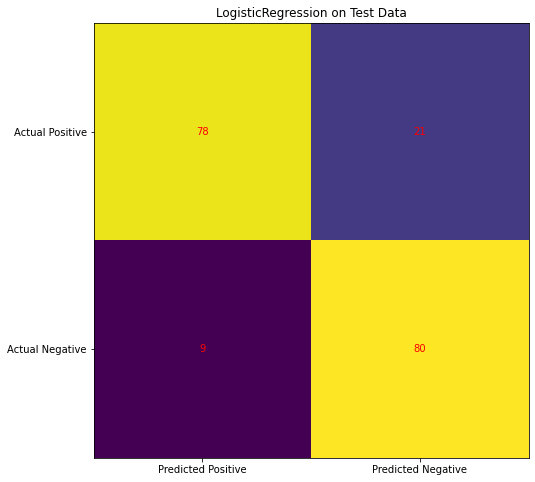

0.8404255319148937
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        99
           1       0.79      0.90      0.84        89

    accuracy                           0.84       188
   macro avg       0.84      0.84      0.84       188
weighted avg       0.85      0.84      0.84       188

CatBoostClassifier
0.967459324155194


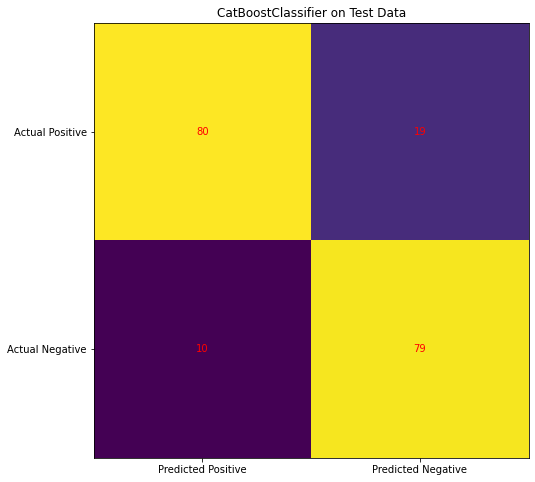

0.8457446808510638
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        99
           1       0.81      0.89      0.84        89

    accuracy                           0.85       188
   macro avg       0.85      0.85      0.85       188
weighted avg       0.85      0.85      0.85       188



In [24]:

df = df_backed_up_for_classification.copy()
def binarizeTarget(x):
    if x <= 2000:
        return 0
    else:
        return 1
df['log_cost'] = df['log_cost'].apply(binarizeTarget)
###################################################################################
cols_to_drop = ['state', 'id',  'year', 'date', 'state_code', 'prec', 'tmpc', 'days_since'] #since days_since is redundant now with it by year
# cols_to_drop = ['state', 'id', 'variable', 'year', 'date', 'state_code', 'value'] #***
df = df.drop(columns=cols_to_drop)
df.drop(columns='log_cost')
X = df.drop(columns=['log_cost', 'num_storms']).copy() #'month',
y = df[['log_cost']].copy()

df_backup_indices = df.copy()
df.sort_values(by=['years_since'], inplace=True)

df['years_since'].value_counts()
split_year = 16
X_train = df[df['years_since'] <= split_year].drop(columns=['log_cost', 'num_storms']).copy()
X_test = df[df['years_since'] > split_year].drop(columns=['log_cost', 'num_storms']).copy()

y_train = df[df['years_since'] <= split_year]['log_cost'].copy()
y_test = df[df['years_since'] > split_year]['log_cost'].copy()

##################################################################################





def plotCM(cm_, title_):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm_)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Positive', 'Predicted Negative'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Positive', 'Actual Negative'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm_[i, j], ha='center', va='center', color='red')
            plt.title(title_)
    plt.show()
    return
    
def callModel(clf,x_train,  y_train, x_test, y_test):
    title = clf.__class__.__name__
    if title == "CatBoostClassifier" or title == "LogisticRegression":
        print(title)
        # print('training')
        clf = clf.fit(x_train, y_train)
        # print('done_training')
        cm = confusion_matrix(y_train, clf.predict(x_train))
        # plotCM(cm, title + ' on Training Data')
        print(accuracy_score(y_train, clf.predict(x_train)))
        cm = confusion_matrix(y_test, clf.predict(x_test))
        plotCM(cm,  title + ' on Test Data')
        print(clf.score(x_test, y_test))
        print(classification_report(y_test, clf.predict(x_test)))

#######################################################################
clf_list = [LogisticRegression(), RandomForestClassifier(max_depth=35), ExtraTreesClassifier(max_depth=30, min_samples_split=3),
            GradientBoostingClassifier(),
            CatBoostClassifier(random_seed=9,logging_level='Silent')]
for clf in clf_list:
    callModel(clf, X_train, y_train, X_test, y_test )
    
    

    


In [25]:
df_backed_up_for_classification

,date,id,prec,tmpc,year,state_code,state,log_cost,num_storms,prec_1,...,years_since,state_encoded,neighbor_prec_1,neighbor_prec_2,neighbor_prec_3,neighbor_prec_5,neighbor_tmpc_1,neighbor_tmpc_2,neighbor_tmpc_3,neighbor_tmpc_5
0,2000-01-01,12000,3.540833,63.566667,2000,1,alabama,5707.362717,937,63.566667,...,0,10,3.025000,3.249271,3.409722,3.602083,3.025000,3.249271,3.409722,3.602083
1,2001-01-01,12001,4.920000,63.033333,2001,1,alabama,4631.627676,755,63.566667,...,1,10,3.025000,3.249271,3.409722,3.602083,3.025000,3.249271,3.409722,3.602083
2,2002-01-01,12002,4.760833,63.575000,2002,1,alabama,4027.848943,728,63.033333,...,2,10,3.473542,3.249271,3.409722,3.602083,3.473542,3.249271,3.409722,3.602083
3,2003-01-01,12003,5.310000,62.733333,2003,1,alabama,4759.658513,1125,63.575000,...,3,10,3.730625,3.602083,3.409722,3.602083,3.730625,3.602083,3.409722,3.602083
4,2004-01-01,12004,4.990000,63.333333,2004,1,alabama,4085.559287,830,62.733333,...,4,10,3.754792,3.742708,3.652986,3.602083,3.754792,3.742708,3.652986,3.602083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,2016-01-01,482016,1.440000,43.908333,2016,48,wisconsin,2737.782236,1102,44.158333,...,16,20,3.548333,3.402708,3.422014,3.282417,3.548333,3.402708,3.422014,3.282417
983,2017-01-01,482017,1.555000,43.200000,2017,48,wisconsin,4179.061507,1322,43.908333,...,17,20,3.348542,3.448438,3.384653,3.299792,3.348542,3.448438,3.384653,3.299792
984,2019-01-01,482019,1.528333,40.275000,2019,48,wisconsin,3608.508245,1511,43.200000,...,19,20,3.372292,3.360417,3.423056,3.397375,3.372292,3.360417,3.423056,3.397375
985,2020-01-01,482020,0.976667,42.775000,2020,48,wisconsin,2206.588840,958,40.275000,...,20,20,3.943125,3.657708,3.554653,3.493875,3.943125,3.657708,3.554653,3.493875


In [18]:
df

,date,id,prec,tmpc,year,state_code,state,log_cost,num_storms,prec_1,...,years_since,state_encoded,neighbor_prec_1,neighbor_prec_2,neighbor_prec_3,neighbor_prec_5,neighbor_tmpc_1,neighbor_tmpc_2,neighbor_tmpc_3,neighbor_tmpc_5
0,2000-01-01,12000,3.540833,63.566667,2000,1,alabama,1,937,63.566667,...,0,10,3.025000,3.249271,3.409722,3.602083,3.025000,3.249271,3.409722,3.602083
1,2001-01-01,12001,4.920000,63.033333,2001,1,alabama,1,755,63.566667,...,1,10,3.025000,3.249271,3.409722,3.602083,3.025000,3.249271,3.409722,3.602083
2,2002-01-01,12002,4.760833,63.575000,2002,1,alabama,1,728,63.033333,...,2,10,3.473542,3.249271,3.409722,3.602083,3.473542,3.249271,3.409722,3.602083
3,2003-01-01,12003,5.310000,62.733333,2003,1,alabama,1,1125,63.575000,...,3,10,3.730625,3.602083,3.409722,3.602083,3.730625,3.602083,3.409722,3.602083
4,2004-01-01,12004,4.990000,63.333333,2004,1,alabama,1,830,62.733333,...,4,10,3.754792,3.742708,3.652986,3.602083,3.754792,3.742708,3.652986,3.602083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,2016-01-01,482016,1.440000,43.908333,2016,48,wisconsin,1,1102,44.158333,...,16,20,3.548333,3.402708,3.422014,3.282417,3.548333,3.402708,3.422014,3.282417
983,2017-01-01,482017,1.555000,43.200000,2017,48,wisconsin,1,1322,43.908333,...,17,20,3.348542,3.448438,3.384653,3.299792,3.348542,3.448438,3.384653,3.299792
984,2019-01-01,482019,1.528333,40.275000,2019,48,wisconsin,1,1511,43.200000,...,19,20,3.372292,3.360417,3.423056,3.397375,3.372292,3.360417,3.423056,3.397375
985,2020-01-01,482020,0.976667,42.775000,2020,48,wisconsin,1,958,40.275000,...,20,20,3.943125,3.657708,3.554653,3.493875,3.943125,3.657708,3.554653,3.493875
